# Cell growth on the standard model for a bioreactor (product excluded)
The goal is to use a simple DGL that displays the characteristic behavior for Substrate consumption and Biomass growth for Data, then train a NN, DMD, or a gaussian Model with it. Afterwards, some values (e.g in the growth rate $\mu(S)$-the Km-value) are in the DGL are changed to generate a new output for the Biomass. Then it is attempted to design an observer, that can make the (now flawed) model converge to the real states.

The system of DGLs that will be used here is :
$$
\begin{aligned}
\dot{b} &= -Db + \rho(s)b \\
\dot{s} &= D(s_e - s) - \rho(s)b
\end{aligned}
$$
with the biomass being the measured output, so that 
$$y(t)=b(t)$$ 



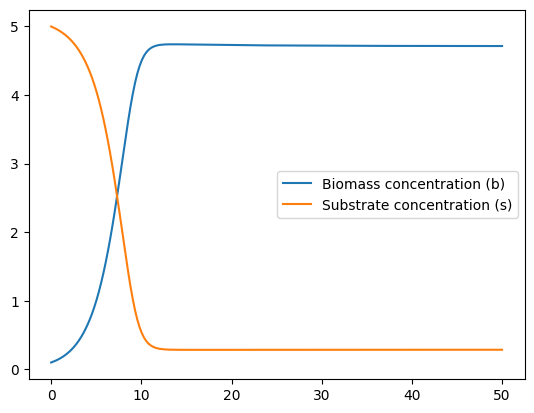

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import helperfunctions as hf


def Biosystem(t, y, D, K_m, s_e, mu_max):
    b, s = y
    rho = mu_max * s / (K_m + s)
    dbdt = -D * b + rho * b
    dsdt = D * (s_e - s) - rho * b
    return [dbdt, dsdt]


# Initial conditions
y0 = [0.1, 5.0]

# Time span
t_span = (0, 50)
t_eval = np.linspace(*t_span, 200)

# Parameter values
D = 0.1         # Dilution rate
K_m = 2          # Monod-constant
s_e = 5         # External substrate concentration
mu_max = 0.8       # Maximum specific growth rate

# Solve ODE
sol = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)

plt.plot(sol.t,sol.y[0], label='Biomass concentration (b)')
plt.plot(sol.t, sol.y[1], label='Substrate concentration (s)')
plt.legend( loc='best')


In [2]:
#creating and storing more datasets with the same parameters but different initial conditions

Dataset={}
#number of datasets=j
j=10
for i in range (j):
    y0 = [0.1 + i * 0.5, 5.0 - i * 0.5]  # Varying initial conditions
    sol_i = solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
    Dataset[f'B{i}'] = sol_i.y[0]
    Dataset[f'S{i}'] = sol_i.y[1]



import torch as torch
import torch.nn as nn

#initializing the neural network class that inherits from nn
dim=2                           #b and s
class Neuralnetwork (nn.Module):
    def __init__(self,dim):
        super(Neuralnetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(),              
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, dim)      
        )
    def forward(self, x):
        return self.model(x)
    
model = Neuralnetwork(dim=dim)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss() #mean squared error loss function --randomly chosen, could also use weighted function
#weighted function may be good, to value the larger Cells more, since the measurement of these is generally more stable than 
#the measurement of small cells


for i in range (0,j):
    X_tensor = torch.tensor(np.array([Dataset[f'B{i}'][:-1],Dataset[f'S{i}'][:-1]]).T, dtype=torch.float32)
    # print(X_tensor.shape)#199 batch with dim 2

    Y_tensor = torch.tensor(np.array([Dataset[f'B{i}'][1:],Dataset[f'S{i}'][1:]]).T, dtype=torch.float32)
    # print(Y_tensor.shape)#199,2

    for epoch in range(i*100,100+i*100):  # Training for 100 epochs per dataset
        optimizer.zero_grad()
        output = model(X_tensor)        #calls the forward function of the Neural Network class
        loss = criterion(output, Y_tensor)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

Epoch 0, Loss: 12.924432
Epoch 100, Loss: 0.004174
Epoch 200, Loss: 0.000380
Epoch 300, Loss: 0.000128
Epoch 400, Loss: 0.000079
Epoch 500, Loss: 0.000052
Epoch 600, Loss: 0.000031
Epoch 700, Loss: 0.000017
Epoch 800, Loss: 0.000009
Epoch 900, Loss: 0.000004


# Validation of the NN with different initial conditions
 
it can be observed, that there is definitely a mismatch between the real trajectory and the predicted trajectory.
-->Checking whether an Observer can help to get the real states of the system, even with wrong initial guess


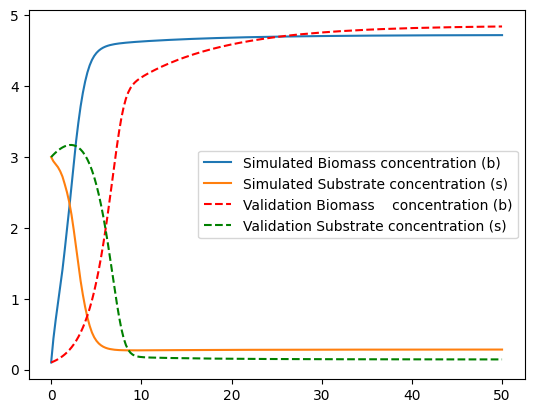

In [3]:
y0=[0.1,3] #initial conditions for the validation with the neural network
K_m=1
validation=solve_ivp(Biosystem, t_span, y0, args=(D, K_m, s_e, mu_max), t_eval=t_eval)
Dataset_val = {}
Dataset_val['B1'] = validation.y[0]
Dataset_val['S1'] = validation.y[1]

##NN simulation
sol_sim=[[0.1,3]]
for i in range (0, len(t_eval)-1):
    sol_prev=sol_sim[i]
    ni=model(torch.tensor(sol_prev,dtype=torch.float32)).detach().numpy()
    sol_sim.append(ni)
plt.plot(t_eval, np.array(sol_sim)[:, 0], label='Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_sim)[:, 1], label='Simulated Substrate concentration (s)')
plt.plot(validation.t, validation.y[0], 'r--', label='Validation Biomass    concentration (b)')
plt.plot(validation.t, validation.y[1], 'g--', label='Validation Substrate concentration (s)')
plt.legend(loc='best')

# DMD
Another Data based modeling approach is using the "Dynamic mode Decomposition", where the data is used to find a best fit linear operator for the approximation of the nonlinear system such that
$$x_{k+1}=A\cdot x_{k}$$

The practical computation uses the singular value decomposition of the snapshot matrices  
SVD of $X = U \Sigma V^T$ and $X' = A X = A U \Sigma V^T$

To solve for $A$, use the pseudoinverse:
$$
A = X' V \Sigma^{-1} U^T
$$

Where:
- $X = [x_1, ..., x_{m-1}]$ (data matrix of snapshots)
- $X' = [x_2, ..., x_m]$ (data matrix shifted by one step)
- $U, \Sigma, V^T$ are from the SVD of $X$.

This gives the best-fit linear operator $A$ such that $x_{k+1} \approx A x_k$.

If it were the case that the system dimension was very large, then the Matrix $A (dim=n\times n$) would also be very large, thus increasing the computational load siginificantly. Then, it would be reasonable to use a reduced order System.
In our case however, the system Dimension is 2, thus the matrix A is of dimension $2 \times 2$. So this won't be necessary.

However the low dimensionality might lead to another Problem :

## Potential Problems: 
Usually the Data-vector is of high dimension. in our case it only has Dimension 2. This means that $A \in 2\times2$ which might not be sufficient to correctly approximate the Nonlinear Dynamics. If that should be the case, we could also look at so called **Hankel DMD's**
Hankel DMDs split the Datavector and  stack the segments  (each shifted by one time index) on top of each other to increase the dimension of the System. 

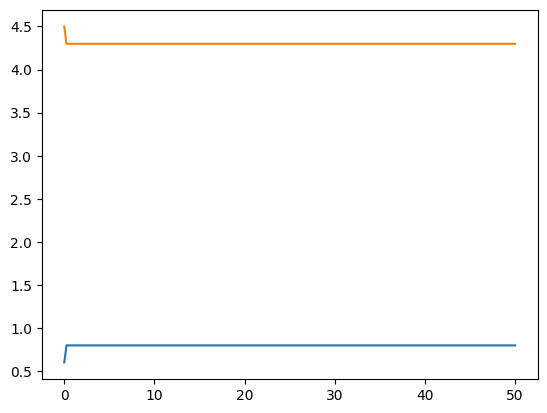

(380, 10)


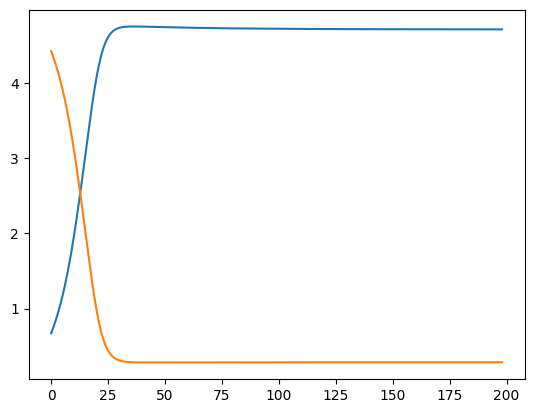

In [ ]:
#DMD of the simulated Dataset
X = np.array([Dataset['B1'][:-1], Dataset['S1'][:-1]])
Xp=np.array([Dataset['B1'][1:], Dataset['S1'][1:]])
A,_,_,_ = hf.compute_DMD(X, Xp)

#now i want to check whether the DMD matrix can predict the next step on the same dataset 
x0 = np.array([Dataset['B1'][0], Dataset['S1'][0]])
for i in range (0, len(t_eval)):
    xi=A@x0
    if i==0:
        sol_dmd=[x0]
    else:
        sol_dmd.append(xi)

plt.plot(t_eval, np.array(sol_dmd)[:, 0], label='DMD Simulated Biomass concentration (b)')
plt.plot(t_eval, np.array(sol_dmd)[:, 1], label='DMD Simulated Substrate concentration (s)')
plt.show()
#As we can see the system is not really capturing the dynamics of the system, so we can attempt the Hankel DMD
#-------------------------------------Hankel DMD------------------------------------

num_columns=10                                         #number of colums to build DMD with
A,_,_,_ = hf.compute_hankel_DMD(X, Xp, cols=num_columns)

#now i want to check whether the Hankel DMD matrix can predict the next step on the same dataset
x0H=hf. stack_snapshots(X=X, cols=num_columns)
# print(A.shape, x0H.shape)
xkH=A@x0H
# print(xkH.shape)
xkH=hf.unstack_snapshots(xkH,2) 
plt.plot(xkH[0,:])
plt.plot(xkH[1,:])
plt.show()

# Unscented Kalman Filter
In this section it will be attempted to use an Unscented Kalman Filter to account for the wrong initial guess of the Substrate concentration.

The key idea of the UFK is to take sample points around the mean of a gaussian variable and then propagate it through the NN, thus using the real model for the dynamics rather than a jacobian. In doing so, the weights attached to the sigma points help to capture the mean and the covariance of the distribution without actual analytical equations of the system dynamics.

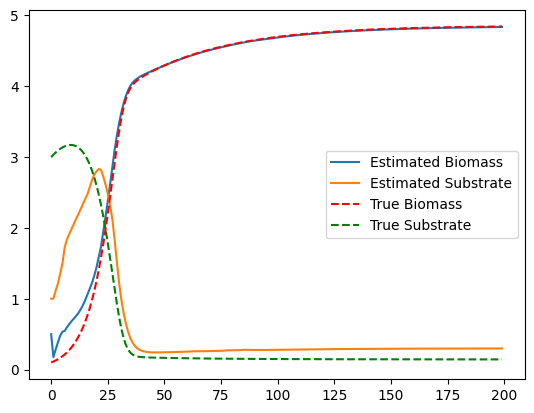

In [5]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints

def f_NN(x,dt):
    """State transition function using the neural network. f(x(t)) = x(t+1)"""
    x_tensor = torch.tensor(x, dtype=torch.float32)
    return model(x_tensor).detach().numpy()

def h(x):
    """Measurement function, in this case only the biomass concentration is measured."""
    return np.array([x[0]])  


# State dimension: 2 (b, s)
# Measurement dimension: 1 (b)
dim_x = 2
dim_z = 1

# Create sigma points object
"""As suggested in the documentation 
-alpha is the "spread of the sigma points around the mean state, values between 0 and 1 are common
-beta affects the weight of the central sigma point, typically set to 2 for Gaussian distributions
-kappa is a secondary scaling parameter, often set to 0 for simplicity."""
points = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0.0)

# Create UKF object
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=f_NN, hx=h, dt=1.0, points=points)

# Initial state guess (e.g., wrong s value)
ukf.x = np.array([0.5, 1])  # Initial guess for [b, s] the real values are [0.1, 3]
# Initial covariance (uncertainty in state)
ukf.P = np.eye(dim_x) * 0.1# You can tune this

# Process noise (model uncertainty)
ukf.Q = np.diag([1e-3, 1e-3])  # Tune this based on how inaccurate your NN is

# Measurement noise (e.g., sensor error in b, but i should not have any noise since i simulated with the ODE for the measurement)
ukf.R = np.array([[0.01]])  # Measurement noise variance

b_measurements = Dataset_val['B1'][0:]  # Use the biomass measurements for updating the filter

estimated_states = [ukf.x.copy()]  # Store the initial state (used for plotting)

for z in b_measurements[1:]:  # Skip the first measurement since i assume the measurement is not available at t=0
    ukf.predict()
    ukf.update(np.array([z]))
    estimated_states.append(ukf.x.copy())


estimated_states = np.array(estimated_states)
plt.plot(estimated_states[:, 0], label='Estimated Biomass')
plt.plot(estimated_states[:, 1], label='Estimated Substrate')
plt.plot(validation.y[0], 'r--', label='True Biomass')
plt.plot(validation.y[1], 'g--', label='True Substrate')
plt.legend()
plt.show()